In [1]:
## Download and unzip Penn-Fudan Pedestrian Dataset
!wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
!unzip PennFudanPed.zip


--2025-09-04 12:13:44--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving to: ‘PennFudanPed.zip’

PennFudanPed.zip    100%[===================>]  51.23M  10.8MB/s    in 6.1s    

2025-09-04 12:13:51 (8.41 MB/s) - ‘PennFudanPed.zip’ saved [53723336/53723336]

Archive:  PennFudanPed.zip
   creating: PennFudanPed/
  inflating: PennFudanPed/added-object-list.txt  
   creating: PennFudanPed/Annotation/
  inflating: PennFudanPed/Annotation/FudanPed00001.txt  
  inflating: PennFudanPed/Annotation/FudanPed00002.txt  
  inflating: PennFudanPed/Annotation/FudanPed00003.txt  
  inflating: PennFudanPed/Annotation/FudanPed00004.txt  
  inflating: PennFudanPed/Annotation/FudanPed00005.txt  
  inflating: PennFudanPed/Annotati

In [2]:
## basic imports
import os
import numpy as np

## torch imports
import torch
import torch.utils.data
from torch.utils.data import Dataset

## torchvision imports
import torchvision
import torchvision.transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

## image utilities
from PIL import Image
import matplotlib.pyplot as plt

## code utilities
import random
import cv2


In [3]:
## Clone vision repo and copy necessary training scripts
!git clone https://github.com/pytorch/vision.git
%cd vision
!git checkout v0.3.0

# Copy training utilities to the parent folder
!cp references/detection/engine.py ../
!cp references/detection/transforms.py ../
!cp references/detection/utils.py ../
!cp references/detection/coco_utils.py ../
!cp references/detection/coco_eval.py ../

# Go back to the parent folder
%cd ..


Cloning into 'vision'...
remote: Enumerating objects: 678171, done.
remote: Counting objects: 100% (843/843), done.
remote: Compressing objects: 100% (789/789), done.
remote: Total 678171 (delta 691), reused 95 (delta 50), pack-reused 677328 (from 2)
Receiving objects: 100% (678171/678171), 1.21 GiB | 17.07 MiB/s, done.
Resolving deltas: 100% (635008/635008), done.
/content/vision
Note: switching to 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at be376084d8 version check against PyTorch's CUDA version

In [5]:
# Import helper modules copied from the PyTorch repo
!rm -rf vision



In [8]:
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py
!wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py




--2025-09-04 12:33:08--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py’

engine.py           100%[===================>]   3.97K  --.-KB/s    in 0s      

2025-09-04 12:33:08 (74.5 MB/s) - ‘engine.py’ saved [4063/4063]

--2025-09-04 12:33:08--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

In [9]:
import utils
import transforms as T
from engine import train_one_epoch, evaluate


In [10]:
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, dir_path, transforms=None):
        self.transforms = transforms
        self.dir_path = dir_path
        self.mask_list = list(sorted(os.listdir(os.path.join(dir_path, "PedMasks"))))
        self.image_list = list(sorted(os.listdir(os.path.join(dir_path, "PNGImages"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.dir_path, "PNGImages", self.image_list[idx])
        mask_path = os.path.join(self.dir_path, "PedMasks", self.mask_list[idx])

        image_obj = Image.open(img_path).convert("RGB")
        mask_obj = Image.open(mask_path)
        mask_obj = np.array(mask_obj)

        obj_ids = np.unique(mask_obj)
        obj_ids = obj_ids[1:]  # Remove background

        masks_obj = mask_obj == obj_ids[:, None, None]

        num_objs = len(obj_ids)
        bboxes = []
        for i in range(num_objs):
            pos = np.where(masks_obj[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            bboxes.append([xmin, ymin, xmax, ymax])

        image_id = torch.tensor([idx])
        masks_obj = torch.as_tensor(masks_obj, dtype=torch.uint8)
        bboxes = torch.as_tensor(bboxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {
            "image_id": image_id,
            "masks": masks_obj,
            "boxes": bboxes,
            "labels": labels,
            "area": area,
            "iscrowd": iscrowd,
        }

        if self.transforms is not None:
            image_obj, target = self.transforms(image_obj, target)

        return image_obj, target

    def __len__(self):
        return len(self.image_list)


In [15]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def modify_model(num_classes):
    # Load COCO-pretrained Mask R-CNN with updated weights argument
    weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
    maskrcnn_model = maskrcnn_resnet50_fpn(weights=weights)

    # Replace the box predictor head for the number of classes
    in_features = maskrcnn_model.roi_heads.box_predictor.cls_score.in_features
    maskrcnn_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Replace the mask predictor head for the number of classes
    in_features_mask = maskrcnn_model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    maskrcnn_model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes
    )

    return maskrcnn_model


In [16]:
def get_transform_data(train):
    transforms = []
    transforms.append(T.ToTensor())  # Convert PIL image to tensor
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))  # Data augmentation for training
    return T.Compose(transforms)

# Initialize datasets with transforms
train_dataset = CustomDataset('/content/PennFudanPed', get_transform_data(train=True))
test_dataset = CustomDataset('/content/PennFudanPed', get_transform_data(train=False))

# Train-test split (last 50 for test)
torch.manual_seed(1)
indices = torch.randperm(len(train_dataset)).tolist()
train_dataset = torch.utils.data.Subset(train_dataset, indices[:-50])
test_dataset = torch.utils.data.Subset(test_dataset, indices[-50:])

# Create data loaders with batch size and collate function
train_data_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=utils.collate_fn
)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, shuffle=False, num_workers=2, collate_fn=utils.collate_fn
)


In [17]:
# Select device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Number of classes: background + person
num_classes = 2

# Load modified Mask R-CNN model
final_model = modify_model(num_classes)
final_model.to(device)

# Setup optimizer (SGD)
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Setup learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)


In [18]:
num_epochs = 5

for epoch in range(num_epochs):
    # Train for one epoch
    train_one_epoch(final_model, optimizer, train_data_loader, device, epoch, print_freq=10)

    # Update the learning rate
    lr_scheduler.step()

    # Evaluate on test dataset
    evaluate(final_model, test_data_loader, device=device)


/content/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  loss_dict = model(images, targets)


Epoch: [0]  [ 0/60]  eta: 0:03:34  lr: 0.000090  loss: 2.7989 (2.7989)  loss_classifier: 0.7391 (0.7391)  loss_box_reg: 0.3618 (0.3618)  loss_mask: 1.6600 (1.6600)  loss_objectness: 0.0351 (0.0351)  loss_rpn_box_reg: 0.0029 (0.0029)  time: 3.5705  data: 0.7972  max mem: 2177
Epoch: [0]  [10/60]  eta: 0:00:43  lr: 0.000936  loss: 1.3645 (1.7236)  loss_classifier: 0.5131 (0.4813)  loss_box_reg: 0.2822 (0.2998)  loss_mask: 0.7159 (0.9190)  loss_objectness: 0.0159 (0.0186)  loss_rpn_box_reg: 0.0045 (0.0048)  time: 0.8608  data: 0.0777  max mem: 3223
Epoch: [0]  [20/60]  eta: 0:00:28  lr: 0.001783  loss: 0.9827 (1.2251)  loss_classifier: 0.2174 (0.3345)  loss_box_reg: 0.2812 (0.2843)  loss_mask: 0.3245 (0.5864)  loss_objectness: 0.0140 (0.0154)  loss_rpn_box_reg: 0.0040 (0.0045)  time: 0.5706  data: 0.0079  max mem: 3223
Epoch: [0]  [30/60]  eta: 0:00:20  lr: 0.002629  loss: 0.5594 (1.0112)  loss_classifier: 0.1052 (0.2548)  loss_box_reg: 0.2750 (0.2839)  loss_mask: 0.1798 (0.4532)  loss_ob

KeyError: 'info'

In [19]:
print(test_data_loader.dataset)
print(hasattr(test_data_loader.dataset, 'coco'))
print(test_data_loader.dataset.coco.dataset.keys())  # should include 'info', 'images', etc.


False


AttributeError: 'Subset' object has no attribute 'coco'

In [20]:
# Access the underlying dataset from the Subset
actual_dataset = test_data_loader.dataset.dataset

print(actual_dataset)
print(hasattr(actual_dataset, 'coco'))

if hasattr(actual_dataset, 'coco'):
    print(actual_dataset.coco.dataset.keys())  # should include 'info', 'images', etc.
else:
    print("Dataset is not COCO or missing 'coco' attribute")


False
Dataset is not COCO or missing 'coco' attribute


In [21]:
num_epochs = 5

for epoch in range(num_epochs):
    # Train for one epoch
    train_one_epoch(final_model, optimizer, train_data_loader, device, epoch, print_freq=10)

    # Update the learning rate
    lr_scheduler.step()

    # Skip evaluation for now, or add your own
    # evaluate(final_model, test_data_loader, device=device)


Epoch: [0]  [ 0/60]  eta: 0:01:11  lr: 0.000090  loss: 0.4364 (0.4364)  loss_classifier: 0.0614 (0.0614)  loss_box_reg: 0.1604 (0.1604)  loss_mask: 0.1900 (0.1900)  loss_objectness: 0.0063 (0.0063)  loss_rpn_box_reg: 0.0183 (0.0183)  time: 1.1962  data: 0.4937  max mem: 3223
Epoch: [0]  [10/60]  eta: 0:00:32  lr: 0.000936  loss: 0.2590 (0.3074)  loss_classifier: 0.0380 (0.0396)  loss_box_reg: 0.0820 (0.1067)  loss_mask: 0.1536 (0.1514)  loss_objectness: 0.0016 (0.0029)  loss_rpn_box_reg: 0.0057 (0.0068)  time: 0.6550  data: 0.0506  max mem: 3223
Epoch: [0]  [20/60]  eta: 0:00:26  lr: 0.001783  loss: 0.2590 (0.2974)  loss_classifier: 0.0380 (0.0393)  loss_box_reg: 0.0820 (0.1007)  loss_mask: 0.1362 (0.1489)  loss_objectness: 0.0008 (0.0022)  loss_rpn_box_reg: 0.0054 (0.0063)  time: 0.6337  data: 0.0077  max mem: 3270
Epoch: [0]  [30/60]  eta: 0:00:19  lr: 0.002629  loss: 0.2807 (0.3093)  loss_classifier: 0.0392 (0.0427)  loss_box_reg: 0.0889 (0.1078)  loss_mask: 0.1364 (0.1503)  loss_ob

In [22]:
torch.save(final_model.state_dict(), 'mask-rcnn-fine_tuned_state_dict.pt')


In [24]:
final_model.eval()


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
final_model.to(device)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

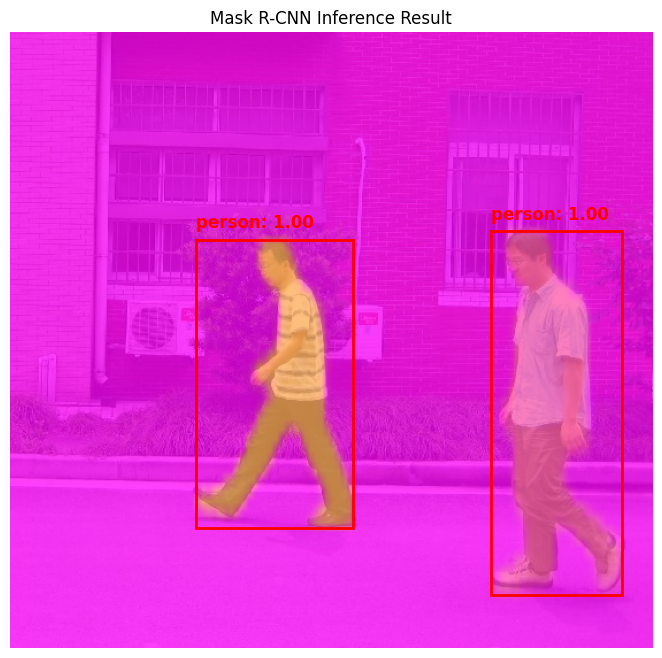

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

# Define class names
CLASSES = ['__background__', 'person']
# Load an image
image_path = '/content/PennFudanPed/PNGImages/FudanPed00001.png'
image = Image.open(image_path).convert("RGB")

# Apply the same transform as during training
image_tensor = F.to_tensor(image).to(device)

# Run inference
with torch.no_grad():
    prediction = final_model([image_tensor])

# Get predictions from output
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()
masks = prediction[0]['masks'].cpu().numpy()

# Visualize top predictions with a confidence threshold
confidence_threshold = 0.5
fig, ax = plt.subplots(1, figsize=(12, 8))
ax.imshow(image)

for idx in range(len(boxes)):
    if scores[idx] >= confidence_threshold:
        # Draw bounding box
        box = boxes[idx]
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                             fill=False, color='red', linewidth=2)
        ax.add_patch(rect)
        ax.text(box[0], box[1] - 10, f'{CLASSES[labels[idx]]}: {scores[idx]:.2f}',
                color='red', fontsize=12, weight='bold')

        # Overlay mask
        mask = masks[idx, 0]
        ax.imshow(mask, alpha=0.5, cmap='spring')

plt.axis('off')
plt.title("Mask R-CNN Inference Result")
plt.show()
